### Загрузка модулей и данных

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [0]:
import torch
import torch.nn.functional as torch_f
from torch.optim import Optimizer
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets

In [0]:
from tqdm import tqdm as tqdm

In [4]:
Xy_mnist = datasets.MNIST('./mnist', train=False, download=True, transform=None)
X_test, y_test = Xy_mnist.test_data, Xy_mnist.test_labels

Xy_mnist = datasets.MNIST('./mnist', train=True, download=True, transform=None)
X_train, y_train = Xy_mnist.train_data, Xy_mnist.train_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [0]:
X_train = X_train.reshape([X_train.shape[0], -1]).float()
X_test = X_test.reshape([X_test.shape[0], -1]).float()

In [6]:
print(X_train.shape, X_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])


### Модель

In [0]:
# Вспомогательные математические функции с https://github.com/mariogeiger/hessian

def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])

def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    Compute the Hessian of `output` with respect to `inputs`
    hessian((x * y).sum(), [x, y])
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)

    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad

    return out

#### Логистическая регресия

In [0]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim=50, output_dim=10, device='cpu'):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.linear = torch.nn.Linear(input_dim, output_dim)        
        self.to(device)
        
    def forward(self, input):
        output = input
        output = torch_f.relu(output)
        return self.linear(output)

### Функции для обучения модели

In [0]:
def train_on_batch(model, batch_x, batch_y, optimizer, loss_function):
    model.zero_grad()
    output = model(batch_x)
        
    loss = loss_function(output, batch_y)
    loss.backward()
    optimizer.step()

    
def train_one_epoch(train_generator, model, loss_function, optimizer):
    model.train()
    for it, (batch_x, batch_y) in enumerate(train_generator):
        train_on_batch(model, batch_x, batch_y, optimizer, loss_function)


def trainer(epochs, batch_size, dataset, model, loss_function, optimizer, progress=None):
    iterations = range(epochs)
    if progress is not None:
        iterations = progress(iterations)
    for it in iterations:
        batch_generator = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
        train_one_epoch(batch_generator, model, loss_function, optimizer)

#### Переопределенный оптимизатор: оптимизировать только те переменые, которые не были удалены

In [0]:
class OptimizerNonDeleted(Optimizer):
    def __init__(self, params, lr=0.001, beta=(0.9, 0.999), eps=0.000001, weight_decay=0, amsgrad=False):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if eps < 0.0:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta[0] < 1.0:
            raise ValueError("Invalid beta[0] parameter: {}".format(beta[0]))
        if not 0.0 <= beta[1] < 1.0:
            raise ValueError("Invalid beta[1] parameter: {}".format(beta[1]))
        defaults = {'lr': lr, 'beta': beta, 'eps': eps, 'weight_decay': weight_decay, 'amsgrad': amsgrad}
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            
    def get_masks_pruning(self):
        list_of_mask = []
        list_prune = []
        mask_vector = None
        for group in self.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                if 'prune' not in param_state:
                    param_state['prune'] = torch.ones_like(p)
                p_vector = p.view(-1)
                prune_vector = param_state['prune'].view(-1)
                list_prune.append(prune_vector)
        mask_vector = torch.cat(list_prune)
        return mask_vector

    def prune(self, amount=0.05, method='random', **kwargs):
        if method == 'random':
            for group in self.param_groups:
                 for p in group['params']:
                    param_state = self.state[p]
                    if 'prune' not in param_state:
                        param_state['prune'] = torch.ones_like(p)

                    p_vector = p.view(-1)
                    prune_vector = param_state['prune'].view(-1)
                    bound = int(amount * len(p_vector))
                    if bound > 0:
                        prune_vector[torch.randperm(p_vector.shape[0])[:bound]] = 0
                        p_vector.data.mul_(prune_vector)

        elif method == 'OBD':
            if kwargs['hessian'] is not None:
                for group in self.param_groups:
                    for p, h in zip(group['params'], kwargs['hessian']):
                        param_state = self.state[p]
                        if 'prune' not in param_state:
                            param_state['prune'] = torch.ones_like(p)

                        p_vector = p.view(-1)
                        score = (p*h).view(-1)
                        prune_vector = param_state['prune'].view(-1)
                        bound = int(amount * len(p_vector))
                        if bound > 0:
                            prune_vector[torch.sort(score)[1][:bound]] = 0
                            p_vector.data.mul_(prune_vector)
    
    def deprune(self):
        for group in self.param_groups:
             for p in group['params']:
                param_state = self.state[p]
                param_state['prune'] = torch.ones_like(p)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue
                    
                d_param = param.grad.data.detach()
                param_state = self.state[param]
    
                if 'prune' in param_state:
                    prune = param_state['prune']
                else:
                    prune = torch.ones_like(param)
                    param_state['prune'] = prune                 
                    
                grad = param.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Does not support sparse gradients, please use SparseAdam')
                amsgrad = group['amsgrad']

                state = self.state[param]
                if 'step' not in state:
                    state['step'] = 0
                if 'exp_avg' not in state:
                    state['exp_avg'] = torch.zeros_like(param.data)
                if 'exp_avg_sq' not in state:
                    state['exp_avg_sq'] = torch.zeros_like(param.data)
                if amsgrad:
                    if 'max_exp_avg_sq' not in state:
                        state['max_exp_avg_sq'] = torch.zeros_like(param.data)
                
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['beta']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], param.data)

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * (bias_correction2 ** (0.5)) / bias_correction1

                param.data.addcdiv_(-step_size, prune * exp_avg, denom)
        return loss

#### Обучение моделей

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [0]:
loss_function = torch.nn.CrossEntropyLoss()

In [0]:
train = TensorDataset(X_train.to(device), y_train.to(device))
test = TensorDataset(X_test.to(device), y_test.to(device))

In [0]:
model = LogisticRegression(input_dim=X_train.shape[1], output_dim=10, device=device)

In [0]:
optimizer = OptimizerNonDeleted(model.parameters())

In [0]:
output = model(train[:][0])
loss = loss_function(output, train[:][1])

In [0]:
def resize_hessian(model, hessian):
    bias = 0
    new_hessian = []
    for param in model.parameters():
        param_size = torch.tensor(param.size()).prod()
        new_hess.append(hessian[bias : bias + param_size].view_as(param))
        bias += param_size
    return new_hessian

In [0]:
with open('hessian.pkl', 'rb') as f:
    hs = pickle.load(f)

In [19]:
amounts = np.linspace(0, 1, 20)
k_for_averaging = 5

list_random_score = []
for amount in tqdm(amounts):
    list_score = []
    for _ in range(k_for_averaging):
        model.load_state_dict(torch.load('train_model.sv'))
        optimizer = OptimizerNonDeleted(model.parameters())
        optimizer.prune(amount=amount, method='random', hessian=hs)

        trainer(epochs=2, batch_size=64, dataset=train, model=model, loss_function = loss_function, optimizer = optimizer)

        output = model(test[:][0])
        output.sum(dim = 1)
        answ = torch.argmax(torch.softmax(output, dim=1), dim=1)

        list_score.append(float((test[:][1] == answ).sum()) / test[:][1].shape[0])
    list_random_score.append(list_score)
  
list_random_score = np.array(list_random_score)

list_OBD_score = []
for amount in tqdm(amounts):
    model.load_state_dict(torch.load('train_model.sv'))
    optimizer = OptimizerNonDeleted(model.parameters())
    optimizer.prune(amount=amount, method='OBD', hessian=hs)

    trainer(epochs=2, batch_size=64, dataset=train, model=model, loss_function=loss_function, optimizer=optimizer)

    output = model(test[:][0])
    output.sum(dim=1)
    answ = torch.argmax(torch.softmax(output, dim=1), dim=1)

    list_OBD_score.append(float((test[:][1] == answ).sum()) / test[:][1].shape[0])
  
list_OBD_score = np.array(list_OBD_score)

100%|██████████| 20/20 [00:58<00:00,  2.81s/it]


In [0]:
random_mean = np.mean(list_random_score, axis = 1)
random_std = np.std(list_random_score, axis = 1)

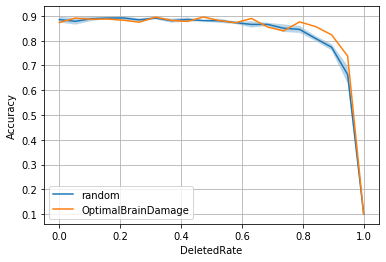

In [21]:
plt.plot(amounts, random_mean, label='random')
plt.fill_between(amounts, random_mean-random_std, random_mean+random_std, alpha=0.3)

plt.plot(amounts, list_OBD_score, label='OptimalBrainDamage')

plt.legend(loc='best')
plt.grid()

plt.xlabel('DeletedRate')
plt.ylabel('Accuracy')
plt.show()

## Вывод

Оба метода --- случайное удаление и Optimal Brain Damage --- позволяют удалить достаточно много (около 70%) нейронов без заметной потери качества. Однако если при случайном удалении качество в среднем монотонно убывает, то Optimal Brain Damage может улучшать качество при дополнительном удалении; этот алгоритм в данном эксперименте сохранил качество, близкое к исходному, при удалении 80% нейронов, а при удалении 90% --- приемлемое и выше, чем у случайного удаления (примерно 0.85 против примерно 0.8). То есть, на экспериментальном уровне Optimal Brain Damage проявил себя лучше.